In [45]:
from io import open

import glob

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os

import random

import string

import time

import torch
import torch.nn as nn

import unicodedata

In [46]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [47]:
all_letters = string.ascii_letters + " .,;'"

In [48]:
n_letters = len(all_letters)

In [49]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [50]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [51]:
print(category_lines['Italian'][300:306])

["D'onofrio", 'Drago', 'Durante', 'Elena', 'Episcopo', 'Ermacora']


In [52]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [53]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [54]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [55]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        # Combine the input and previous hidden state into a combined state
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        output = self.fc(output[:, -1, :])  # Take the output of the last time step
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)  # Hidden state and cell state

In [56]:
n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [57]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [58]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Bell
category = Russian / line = Moshninov
category = English / line = Clifton
category = Arabic / line = Harb
category = Czech / line = Weineltk
category = Korean / line = Moon
category = Italian / line = Mancini
category = Czech / line = Schwartz
category = Italian / line = Cucinotta
category = Scottish / line = Ferguson


In [59]:
criterion = nn.NLLLoss()

In [60]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden, cell = lstm.initHidden()

    lstm.zero_grad()

    # Since the input is 2-D (sequence_length x input_size), we need to add a batch dimension
    line_tensor = line_tensor.unsqueeze(0)  # Now line_tensor is 3-D (1 x sequence_length x input_size)

    for i in range(line_tensor.size()[1]):  # Notice the change here from 0 to 1 for the dimension
        output, hidden, cell = lstm(line_tensor[:, i, :], hidden, cell)  # Pass the i-th time step across the batch

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [61]:
n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 24s) 2.9072 Simpson / Korean ✗ (Scottish)
10000 10% (0m 48s) 2.9212 Pender / Dutch ✗ (English)
15000 15% (1m 17s) 2.8075 Martin / Irish ✗ (Scottish)
20000 20% (1m 42s) 2.6772 Chung / Korean ✗ (Vietnamese)
25000 25% (2m 6s) 2.1561 Lin / Vietnamese ✗ (Chinese)
30000 30% (2m 33s) 3.2886 Huff / Korean ✗ (German)
35000 35% (2m 59s) 2.1420 Paredes / Greek ✗ (Portuguese)
40000 40% (3m 24s) 2.1162 Fugunaga / Spanish ✗ (Japanese)
45000 45% (3m 50s) 2.2035 Forst / Czech ✗ (German)
50000 50% (4m 16s) 2.0816 Zogby / Arabic ✓
55000 55% (4m 42s) 0.7839 Shalhoub / Arabic ✓
60000 60% (5m 7s) 3.1652 Pech / Vietnamese ✗ (Czech)
65000 65% (5m 32s) 3.2079 Philips / Greek ✗ (Dutch)
70000 70% (5m 58s) 2.2451 Groel / French ✗ (German)
75000 75% (6m 21s) 1.4574 Pelletier / French ✓
80000 80% (6m 50s) 2.9544 Paternoster / German ✗ (Italian)
85000 85% (7m 18s) 1.3949 Cuan / Vietnamese ✗ (Chinese)
90000 90% (7m 45s) 1.1337 Jin / Korean ✗ (Chinese)
95000 95% (8m 11s) 0.4966 Panders / Dutch ✓
100000 10

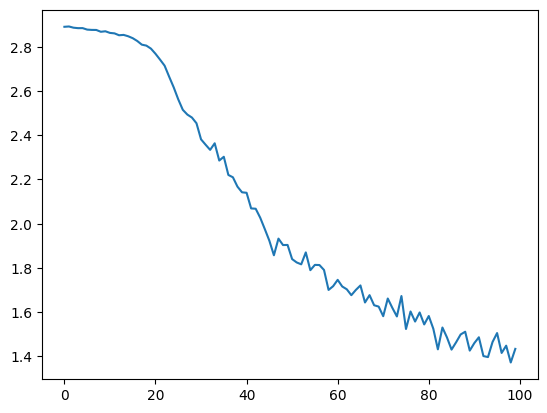

In [62]:
plt.figure()
plt.plot(all_losses)

In [66]:
def evaluate(line_tensor):
    hidden, cell = lstm.initHidden()

    # Since the input is 2-D (sequence_length x input_size), we need to add a batch dimension
    line_tensor = line_tensor.unsqueeze(0)  # Now line_tensor is 3-D (1 x sequence_length x input_size)

    for i in range(line_tensor.size()[1]):  # Iterate over sequence length
        output, hidden, cell = lstm(line_tensor[:, i, :], hidden, cell)

    return output

C:\Users\layor\AppData\Local\Temp\ipykernel_29220\1588391092.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\layor\AppData\Local\Temp\ipykernel_29220\1588391092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


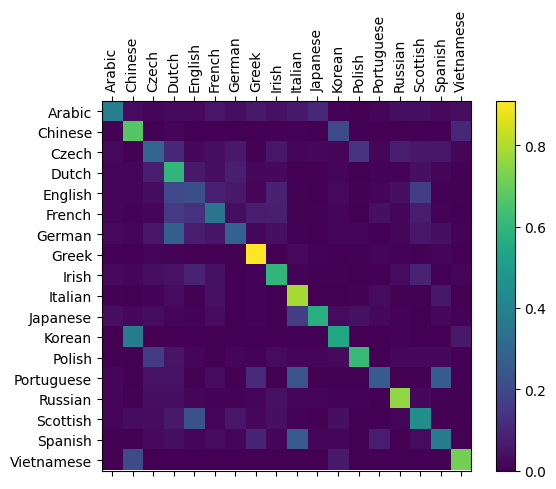

In [67]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [68]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [69]:
predict('Zamek')
predict('Jackson')
predict('Satoshi')


> Zamek
(-0.78) Polish
(-1.18) Czech
(-2.22) Dutch

> Jackson
(-0.43) Scottish
(-1.78) English
(-2.87) Dutch

> Satoshi
(-0.51) Japanese
(-1.87) Polish
(-2.23) Italian


In [70]:
predict("Ayanami")
predict("Kowalski")
predict("Dostoevsky")


> Ayanami
(-0.40) Japanese
(-1.54) Italian
(-2.87) Arabic

> Kowalski
(-0.10) Polish
(-2.99) Czech
(-3.83) Russian

> Dostoevsky
(-0.08) Russian
(-3.03) Czech
(-4.79) Polish
